In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque



In [2]:
class PortfolioEnv:
    def __init__(self, data):
        self.data = data
        self.sector_names = list(data['Sector'].unique())
        self.n_assets = len(self.sector_names)
        self.obs_features = ['Solvency', 'Profitability', 'News Sentiment']
        self.weight_bins = [0.0, 0.5, 1.0]
        from itertools import product
        self.possible_allocations = [
            np.array(w) for w in product(self.weight_bins, repeat=self.n_assets) if 0.99 <= np.sum(w) <= 1.01
        ]
        self.action_size = len(self.possible_allocations)
        self.unique_dates = sorted(self.data['Date'].unique())
        self.max_obs_len = None
        self.current_step = 0

    def reset(self):
        self.unique_dates = sorted(self.data['Date'].unique())
        self.current_step = 0
        return self.get_obs()

    def get_obs(self):
        obs = []
        current_date = self.unique_dates[self.current_step]
        for sector in self.sector_names:
            row = self.data[(self.data['Date'] == current_date) & (self.data['Sector'] == sector)]
            obs.extend(row[self.obs_features].values.flatten())
        obs_array = np.array(obs, dtype=np.float32)
        if self.max_obs_len is None:
            self.max_obs_len = obs_array.shape[0]
        else:
            if obs_array.shape[0] != self.max_obs_len:
                                obs_array = np.resize(obs_array, self.max_obs_len)
        return obs_array

    def _get_portfolio_return(self, allocations):
        cur_date = self.unique_dates[self.current_step]
        next_date = self.unique_dates[min(self.current_step + 1, len(self.unique_dates) - 1)]
        returns = []
        for i, sector in enumerate(self.sector_names):
            df_cur = self.data[(self.data['Date'] == cur_date) & (self.data['Sector'] == sector)]
            df_next = self.data[(self.data['Date'] == next_date) & (self.data['Sector'] == sector)]
            if df_cur.empty or df_next.empty:
                returns.append(0.0)
                continue
            r = (df_next['Price'].values[0] - df_cur['Price'].values[0]) / df_cur['Price'].values[0]
            returns.append(allocations[i] * r)
        return sum(returns)

    
    def step(self, action):
        allocations = self.possible_allocations[action]
        reward = self._get_portfolio_return(allocations)
        self.current_step += 1
        done = self.current_step >= (len(self.unique_dates) - 1)
        obs = self.get_obs() if not done else np.zeros_like(self.get_obs())
        return obs, reward, done


In [3]:
import pandas as pd
from stable_baselines3 import DQN
from stable_baselines3.common.env_checker import check_env
import os

In [4]:
# --- File paths ---
sentiment_path = "sector_sentiment_with_metrics_quarterly_2014_2024.csv"
price_path = "stock_return_data.csv"
macro_path = "economic_indicators_quarterly_2014_2024.csv"
ratios_dir = "ratios"

In [5]:
# --- Load and reshape sentiment ---
sentiment = pd.read_csv(sentiment_path)
sentiment = sentiment.melt(id_vars=["Date"], var_name="Sector", value_name="News Sentiment")
sentiment["Date"] = pd.to_datetime(sentiment["Date"])
sentiment["Sector"] = sentiment["Sector"].str.replace("weighted_sentiment_", "", regex=False)


/tmp/ipykernel_3119714/4149681160.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sentiment["Date"] = pd.to_datetime(sentiment["Date"])


In [6]:
# --- Load and convert daily prices to quarterly ---
prices = pd.read_csv(price_path)
prices = prices.rename(columns={"DlyCalDt": "Date", "DlyRet": "Price"})
prices["Date"] = pd.to_datetime(prices["Date"])
prices["Date"] = prices["Date"].dt.to_period("Q").dt.to_timestamp("Q")


/tmp/ipykernel_3119714/3065536591.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  prices["Date"] = pd.to_datetime(prices["Date"])


In [7]:
# Add full sector map for tickers
ticker_sector_map = {
    "AAPL": "Technology", "AMD": "AI/Chip Manufacturing", "AMZN": "Technology", 
    "AVGO": "AI/Chip Manufacturing", "AX": "Finance/Banking", "BAC": "Finance/Banking", 
    "BAX": "Healthcare", "BLK": "Finance/Banking", "F": "Automotive", 
    "GM": "Automotive", "GOOGL": "Technology", "GS": "Finance/Banking", 
    "IBM": "Technology", "INTC": "AI/Chip Manufacturing", "JNJ": "Healthcare", 
    "JPM": "Finance/Banking", "META": "Technology", "MRK": "Healthcare", 
    "MRNA": "Healthcare", "MS": "Finance/Banking", "MSFT": "Technology", 
    "NFLX": "Technology", "NVDA": "AI/Chip Manufacturing", "PFE": "Healthcare", 
    "TSLA": "Automotive", "TM": "Automotive", "TSLA": "Automotive", 
    "TSMC": "AI/Chip Manufacturing", "WFC": "Finance/Banking"
}
prices["Sector"] = prices["Ticker"].map(ticker_sector_map)
prices = prices.dropna(subset=["Sector"])


In [8]:
# --- Load macro data ---
macro = pd.read_csv(macro_path)
macro["Date"] = pd.to_datetime(macro["Date"])



/tmp/ipykernel_3119714/106066966.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  macro["Date"] = pd.to_datetime(macro["Date"])


In [9]:
# --- Build sector-level ratios ---
from itertools import product

files = [f for f in os.listdir(ratios_dir) if f.endswith("_ratios.csv")]
all_data = []

for file in files:
    ticker = file.replace("_ratios.csv", "")
    sector = ticker_sector_map.get(ticker)
    if sector:
        df = pd.read_csv(os.path.join(ratios_dir, file))
        df["Ticker"] = ticker
        df["Sector"] = sector
        all_data.append(df)

ratios_df = pd.concat(all_data, ignore_index=True)
ratios_df = ratios_df.rename(columns={"date": "Date"})
ratios_df["Date"] = pd.to_datetime(ratios_df["Date"])
ratios_df["Date"] = ratios_df["Date"].dt.to_period("Q").dt.to_timestamp("Q")
ratios_df = ratios_df.rename(columns={
    "return_on_assets": "Profitability",
    "debt_to_equity_ratio": "Solvency"
})
ratios_df = ratios_df.dropna(subset=["Solvency", "Profitability"])

sector_ratios = (
    ratios_df[["Date", "Sector", "Solvency", "Profitability"]]
    .groupby(["Date", "Sector"])
    .mean()
    .reset_index()
)


In [10]:
# --- Final merge ---
df = sentiment.merge(prices, on=["Date", "Sector"], how="inner")
df = df.merge(sector_ratios, on=["Date", "Sector"], how="inner")
df = df.merge(macro, on="Date", how="left")

print("Final RL dataset shape:", df.shape)
df.head()

Final RL dataset shape: (60450, 25)


,Date,Sector,News Sentiment,Ticker,DlyCap,Price,Solvency,Profitability,RGDP,NGDP,...,X5MT,X10YT,BBB,X30YC,PR,DJI,ORE,CREPI,VIX,X103S
0,2014-03-31,AI/Chip Manufacturing,2.5346,INTC,128098930.0,-0.006357,1.265396,0.017765,17953.974,17197.738,...,1.6034,2.7654,3.7408,4.3646,3.25,1834.307,162.5083,209207,14.8289,2.7161
1,2014-03-31,AI/Chip Manufacturing,2.5346,INTC,128049260.0,-0.000388,1.265396,0.017765,17953.974,17197.738,...,1.6034,2.7654,3.7408,4.3646,3.25,1834.307,162.5083,209207,14.8289,2.7161
2,2014-03-31,AI/Chip Manufacturing,2.5346,INTC,126459820.0,-0.012413,1.265396,0.017765,17953.974,17197.738,...,1.6034,2.7654,3.7408,4.3646,3.25,1834.307,162.5083,209207,14.8289,2.7161
3,2014-03-31,AI/Chip Manufacturing,2.5346,INTC,127080695.0,0.004910,1.265396,0.017765,17953.974,17197.738,...,1.6034,2.7654,3.7408,4.3646,3.25,1834.307,162.5083,209207,14.8289,2.7161
4,2014-03-31,AI/Chip Manufacturing,2.5346,INTC,126310810.0,-0.006058,1.265396,0.017765,17953.974,17197.738,...,1.6034,2.7654,3.7408,4.3646,3.25,1834.307,162.5083,209207,14.8289,2.7161


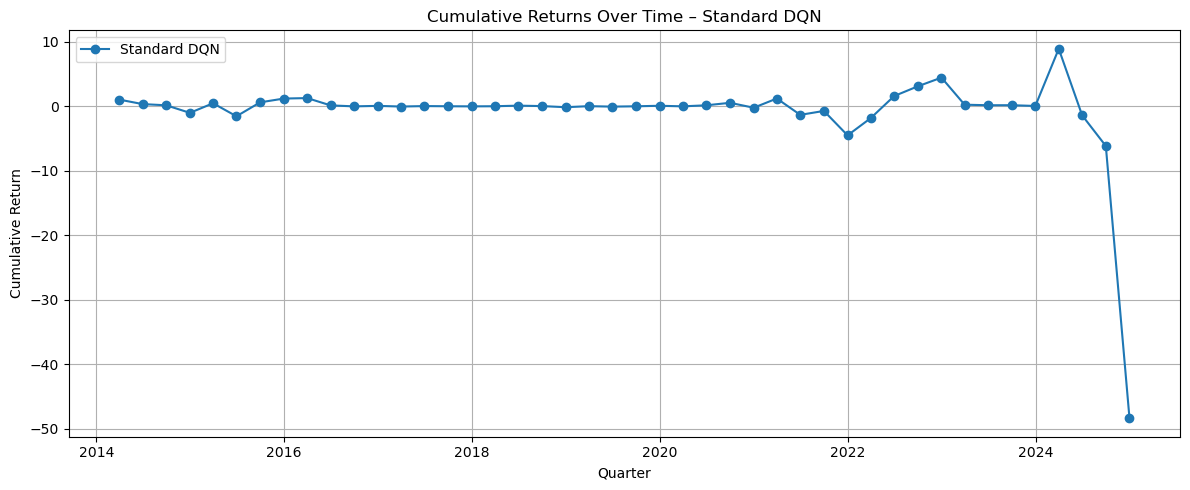

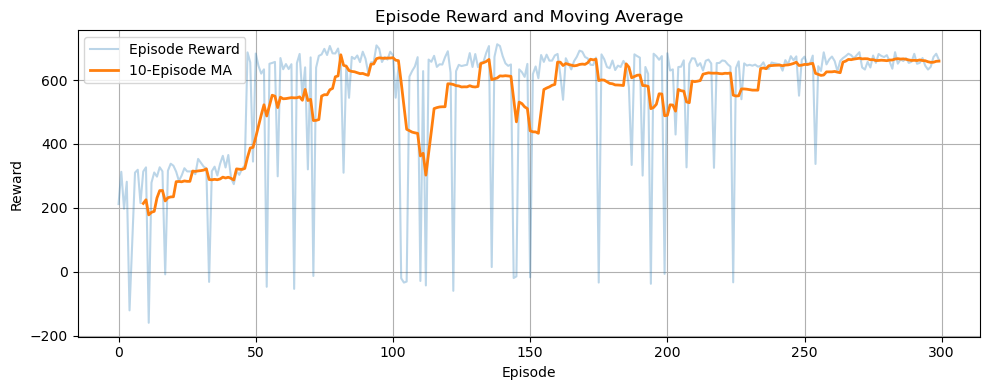

Final Episode Reward: 662.67
Min Reward: -160.00
Max Reward: 712.07
Avg Reward: 545.50


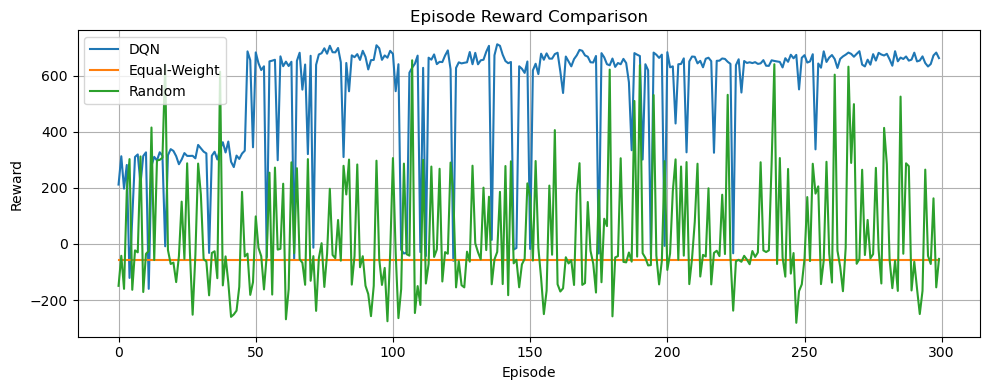

In [11]:
# --- DQN Model ---
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        if len(x.shape) == 1:
            x = x.unsqueeze(0)
        return self.fc(x)

# --- Hyperparameters ---
epsilon = 0.1
gamma = 0.99
lr = 1e-3
buffer_size = 10000
batch_size = 64
num_episodes = 300

# --- Training Setup ---
env = PortfolioEnv(df)
state = env.reset()
state_dim = state.shape[0]
action_dim = env.action_size

q_net = DQN(state_dim, action_dim)
target_net = DQN(state_dim, action_dim)
target_net.load_state_dict(q_net.state_dict())
optimizer = optim.Adam(q_net.parameters(), lr=lr)
replay_buffer = deque(maxlen=buffer_size)

all_rewards = []

for ep in range(num_episodes):
    state = env.reset()
    total_reward = 0
    done = False
    while not done:
        if random.random() < epsilon:
            action = random.randint(0, action_dim - 1)
        else:
            with torch.no_grad():
                state_tensor = torch.tensor(state[:state_dim], dtype=torch.float32)
                if len(state_tensor.shape) == 1:
                    state_tensor = state_tensor.unsqueeze(0)
                action = q_net(state_tensor).argmax().item()

        next_state, reward, done = env.step(action)
        replay_buffer.append((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward

        if len(replay_buffer) >= batch_size:
            batch = random.sample(replay_buffer, batch_size)
            states, actions, rewards, next_states, dones = zip(*batch)
            states = torch.stack([torch.tensor(s, dtype=torch.float32) for s in states])
            actions = torch.tensor(actions).unsqueeze(1)
            rewards = torch.tensor(rewards, dtype=torch.float32)
            next_states = torch.stack([torch.tensor(s[:state_dim], dtype=torch.float32) for s in next_states])
            dones = torch.tensor(dones, dtype=torch.float32)

            q_values = q_net(states).gather(1, actions)
            next_q_values = target_net(next_states).max(1)[0].detach()
            expected_q = rewards + gamma * next_q_values * (1 - dones)

            loss = nn.functional.mse_loss(q_values.squeeze(), expected_q)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    if ep % 10 == 0:
        target_net.load_state_dict(q_net.state_dict())
    all_rewards.append(total_reward)


# --- Plot ---
# Cumulative Return Over Time – Standard DQN Only

standard_env = PortfolioEnv(df)
standard_state = standard_env.reset()
standard_cum_returns = [1.0]  # start with $1 portfolio

for _ in range(len(standard_env.unique_dates) - 1):
    with torch.no_grad():
        state_tensor = torch.tensor(standard_state[:state_dim], dtype=torch.float32).unsqueeze(0)
        action = q_net(state_tensor).argmax().item()
    next_state, reward, done = standard_env.step(action)
    standard_cum_returns.append(standard_cum_returns[-1] * (1 + reward))
    standard_state = next_state

# 📅 Plot over calendar time
plt.figure(figsize=(12, 5))
dates = sorted(df['Date'].unique())
plt.plot(dates[:len(standard_cum_returns)], standard_cum_returns, marker='o', label="Standard DQN")
plt.title("Cumulative Returns Over Time – Standard DQN")
plt.xlabel("Quarter")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# 2. Per-episode rewards + Moving Average
plt.figure(figsize=(10, 4))
plt.plot(all_rewards, alpha=0.3, label="Episode Reward")
plt.plot(pd.Series(all_rewards).rolling(10).mean(), label="10-Episode MA", linewidth=2)
plt.title("Episode Reward and Moving Average")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 3. Print Reward Summary
print(f"Final Episode Reward: {all_rewards[-1]:.2f}")
print(f"Min Reward: {min(all_rewards):.2f}")
print(f"Max Reward: {max(all_rewards):.2f}")
print(f"Avg Reward: {np.mean(all_rewards):.2f}")

# 4. Equal-Weight Baseline
baseline_env = PortfolioEnv(df)
baseline_rewards = []
equal_weight = np.full(baseline_env.n_assets, 1 / baseline_env.n_assets)
baseline_action = min(
    range(len(baseline_env.possible_allocations)),
    key=lambda i: np.sum(np.abs(baseline_env.possible_allocations[i] - equal_weight))
)

for _ in range(num_episodes):
    state = baseline_env.reset()
    done = False
    total_reward = 0
    while not done:
        _, reward, done = baseline_env.step(baseline_action)
        total_reward += reward
    baseline_rewards.append(total_reward)

# 5. Random Baseline
random_env = PortfolioEnv(df)
random_rewards = []

for _ in range(num_episodes):
    state = random_env.reset()
    done = False
    total_reward = 0
    while not done:
        action = random.randint(0, random_env.action_size - 1)
        _, reward, done = random_env.step(action)
        total_reward += reward
    random_rewards.append(total_reward)

# Plot Comparison
plt.figure(figsize=(10, 4))
plt.plot(all_rewards, label="DQN")
plt.plot(baseline_rewards, label="Equal-Weight")
plt.plot(random_rewards, label="Random")
plt.title("Episode Reward Comparison")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
def sharpe_ratio(rewards, risk_free=0.0):
    rewards = np.array(rewards)
    excess_return = rewards - risk_free
    std = np.std(excess_return)
    if std < 1e-5:
        return 0.0
    return np.mean(excess_return) / std

standard_dqn_sharpe = sharpe_ratio(all_rewards)
standard_dqn_return = np.sum(all_rewards)

print(f"Sharpe Ratio (Standard DQN): {standard_dqn_sharpe:.2f}")
print(f"Total Return (Standard DQN): {standard_dqn_return:.2f}")


Sharpe Ratio (Standard DQN): 2.61
Total Return (Standard DQN): 163648.83


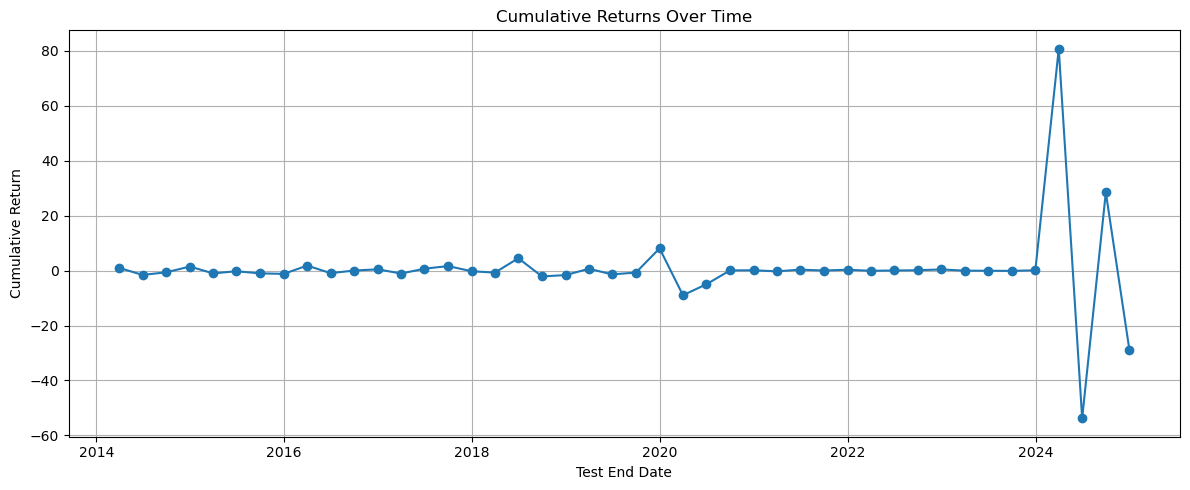

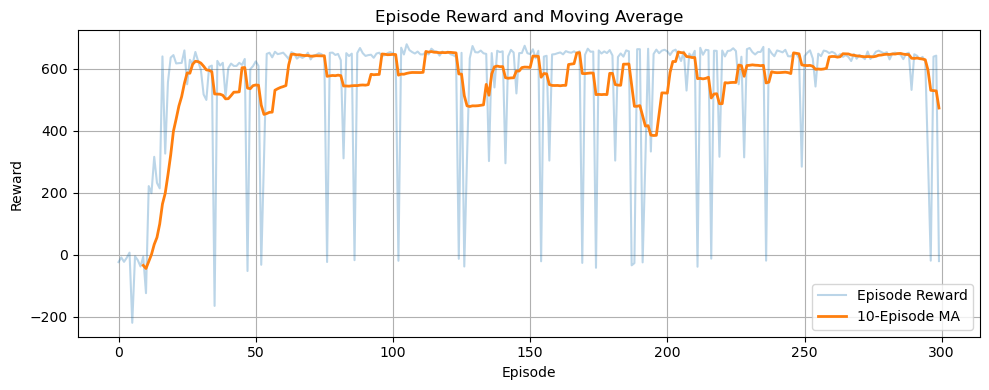

Final Episode Reward: -21.23
Min Reward: -220.30
Max Reward: 678.29
Avg Reward: 550.22


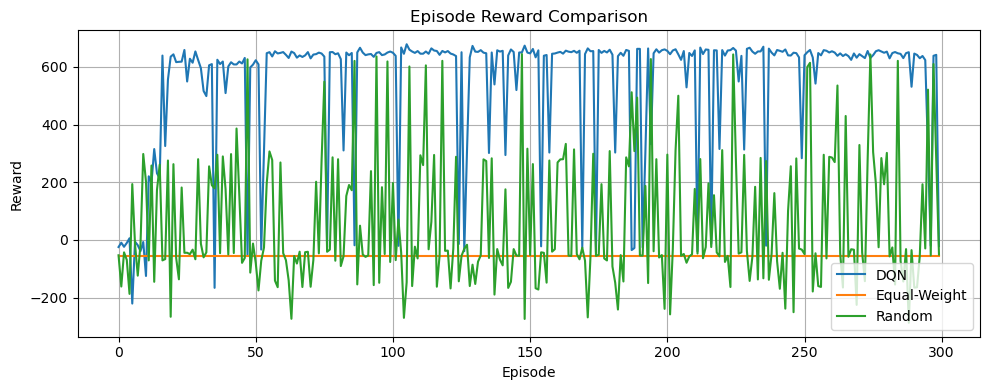

Sharpe Ratios
Rainbow DQN: 2.55
Equal-Weight: 0.00
Random: 0.27
Standard DQN: not available (❌ missing dqn_rewards list)
Total Return
Rainbow DQN: 165065.88
Equal-Weight: -16750.31
Random: 17998.37
Standard DQN: not available (❌ missing dqn_rewards list)


In [15]:
# --- Rainbow DQN Model ---
class RainbowDQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(RainbowDQN, self).__init__()
        self.feature_layer = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
        )
        self.value_stream = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        self.advantage_stream = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        if len(x.shape) == 1:
            x = x.unsqueeze(0)
        features = self.feature_layer(x)
        values = self.value_stream(features)
        advantages = self.advantage_stream(features)
        q_vals = values + (advantages - advantages.mean(dim=1, keepdim=True))
        return q_vals

# --- Hyperparameters ---
epsilon = 0.1
gamma = 0.99
lr = 1e-3
buffer_size = 10000
batch_size = 64
num_episodes = 300

# --- Training Setup ---
env = PortfolioEnv(df)
state = env.reset()
state_dim = state.shape[0]
action_dim = env.action_size

q_net = RainbowDQN(state_dim, action_dim)
target_net = RainbowDQN(state_dim, action_dim)
target_net.load_state_dict(q_net.state_dict())
optimizer = optim.Adam(q_net.parameters(), lr=lr)
replay_buffer = deque(maxlen=buffer_size)

all_rewards = []

for ep in range(num_episodes):
    state = env.reset()
    total_reward = 0
    done = False
    while not done:
        if random.random() < epsilon:
            action = random.randint(0, action_dim - 1)
        else:
            with torch.no_grad():
                state_tensor = torch.tensor(state[:state_dim], dtype=torch.float32)
                if len(state_tensor.shape) == 1:
                    state_tensor = state_tensor.unsqueeze(0)
                action = q_net(state_tensor).argmax().item()

        next_state, reward, done = env.step(action)
        replay_buffer.append((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward

        if len(replay_buffer) >= batch_size:
            batch = random.sample(replay_buffer, batch_size)
            states, actions, rewards, next_states, dones = zip(*batch)
            states = torch.stack([torch.tensor(s, dtype=torch.float32) for s in states])
            actions = torch.tensor(actions).unsqueeze(1)
            rewards = torch.tensor(rewards, dtype=torch.float32)
            next_states = torch.stack([torch.tensor(s[:state_dim], dtype=torch.float32) for s in next_states])
            dones = torch.tensor(dones, dtype=torch.float32)

            q_values = q_net(states).gather(1, actions)
            next_q_values = target_net(next_states).max(1)[0].detach()
            expected_q = rewards + gamma * next_q_values * (1 - dones)

            loss = nn.functional.mse_loss(q_values.squeeze(), expected_q)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    if ep % 10 == 0:
        target_net.load_state_dict(q_net.state_dict())
    all_rewards.append(total_reward)

# --- Plot ---
# 1. Cumulative Return Over Time (Stepwise)
stepwise_env = PortfolioEnv(df)
stepwise_state = stepwise_env.reset()
cum_returns = [1.0]  # start with $1 portfolio

for _ in range(len(stepwise_env.unique_dates) - 1):
    with torch.no_grad():
        state_tensor = torch.tensor(stepwise_state[:state_dim], dtype=torch.float32).unsqueeze(0)
        action = q_net(state_tensor).argmax().item()
    next_state, reward, done = stepwise_env.step(action)
    cum_returns.append(cum_returns[-1] * (1 + reward))
    stepwise_state = next_state

# Plot time-indexed cumulative return
plt.figure(figsize=(12, 5))
dates = sorted(df['Date'].unique())
plt.plot(dates[:len(cum_returns)], cum_returns, marker='o')
plt.title("Cumulative Returns Over Time")
plt.xlabel("Test End Date")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Per-episode rewards + Moving Average
plt.figure(figsize=(10, 4))
plt.plot(all_rewards, alpha=0.3, label="Episode Reward")
plt.plot(pd.Series(all_rewards).rolling(10).mean(), label="10-Episode MA", linewidth=2)
plt.title("Episode Reward and Moving Average")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 3. Print Reward Summary
print(f"Final Episode Reward: {all_rewards[-1]:.2f}")
print(f"Min Reward: {min(all_rewards):.2f}")
print(f"Max Reward: {max(all_rewards):.2f}")
print(f"Avg Reward: {np.mean(all_rewards):.2f}")

# 4. Equal-Weight Baseline
baseline_env = PortfolioEnv(df)
baseline_rewards = []
equal_weight = np.full(baseline_env.n_assets, 1 / baseline_env.n_assets)
baseline_action = min(
    range(len(baseline_env.possible_allocations)),
    key=lambda i: np.sum(np.abs(baseline_env.possible_allocations[i] - equal_weight))
)

for _ in range(num_episodes):
    state = baseline_env.reset()
    done = False
    total_reward = 0
    while not done:
        _, reward, done = baseline_env.step(baseline_action)
        total_reward += reward
    baseline_rewards.append(total_reward)

# 5. Random Baseline
random_env = PortfolioEnv(df)
random_rewards = []

for _ in range(num_episodes):
    state = random_env.reset()
    done = False
    total_reward = 0
    while not done:
        action = random.randint(0, random_env.action_size - 1)
        _, reward, done = random_env.step(action)
        total_reward += reward
    random_rewards.append(total_reward)

# Plot Comparison
plt.figure(figsize=(10, 4))
plt.plot(all_rewards, label="DQN")
plt.plot(baseline_rewards, label="Equal-Weight")
plt.plot(random_rewards, label="Random")
plt.title("Episode Reward Comparison")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 6. Sharpe Ratio and Total Return

def sharpe_ratio(rewards, risk_free=0.0):
    rewards = np.array(rewards)
    excess_return = rewards - risk_free
    std = np.std(excess_return)
    if std < 1e-5:
        return 0.0  # Prevent division by near-zero
    return np.mean(excess_return) / std

print("Sharpe Ratios")
print(f"Rainbow DQN: {sharpe_ratio(all_rewards):.2f}")
print(f"Equal-Weight: {sharpe_ratio(baseline_rewards):.2f}")
print(f"Random: {sharpe_ratio(random_rewards):.2f}")
print("Standard DQN: not available (❌ missing dqn_rewards list)")

print("Total Return")
print(f"Rainbow DQN: {np.sum(all_rewards):.2f}")
print(f"Equal-Weight: {np.sum(baseline_rewards):.2f}")
print(f"Random: {np.sum(random_rewards):.2f}")
print("Standard DQN: not available (❌ missing dqn_rewards list)")



In [16]:
# 6. Sharpe Ratio and Total Return

def sharpe_ratio(rewards, risk_free=0.0):
    rewards = np.array(rewards)
    excess_return = rewards - risk_free
    std = np.std(excess_return)
    if std < 1e-5:
        return 0.0  # Prevent division by near-zero
    return np.mean(excess_return) / std

print("Sharpe Ratios")
print(f"DQN: {sharpe_ratio(all_rewards):.2f}")
print(f"Equal-Weight: {sharpe_ratio(baseline_rewards):.2f}")
print(f"Random: {sharpe_ratio(random_rewards):.2f}")

print("Total Return")
print(f"DQN: {np.sum(all_rewards):.2f}")
print(f"Equal-Weight: {np.sum(baseline_rewards):.2f}")
print(f"Random: {np.sum(random_rewards):.2f}")

Sharpe Ratios
DQN: 2.55
Equal-Weight: 0.00
Random: 0.27
Total Return
DQN: 165065.88
Equal-Weight: -16750.31
Random: 17998.37
